# Tidy Data

> Structuring datasets to facilitate analysis [(Wickham 2014)](http://www.jstatsoft.org/v59/i10/paper)

If there's one maxim I can impart it's that your tools shouldn't get in the way of your analysis. Your problem is already difficult enough.

## The Rules

In a tidy dataset...

1. Each variable forms a column
2. Each observation forms a row
3. Each type of observational unit forms a table

We'll cover a few methods that help you get there.

Based on [this](http://stackoverflow.com/questions/22695680/python-pandas-timedelta-specific-rows) StackOverflow question.

**How many days of rest did each team get between each game?**

In [38]:
tables = pd.read_html("http://www.basketball-reference.com/leagues/NBA_2015_games.html")
games = tables[0]
games.to_csv('data/games.csv')
games.columns = ['date', '_', 'away_team', 'away_points', 'home_team', 'home_points', 'n_ot', 'notes']
games = games.drop(['_', 'notes'], axis=1)
games['date'] = pd.to_datetime(games.date)
games['n_ot'] = (games.n_ot.replace((np.nan, 'OT'), ('0', '1'))
                      .str.extract('(\d)')
                      .astype(int))
games.to_csv('data/tidy_date_games.csv', index=False)
games.head()

,date,away_team,away_points,home_team,home_points,n_ot,notes
0,2014-10-28,Houston Rockets,108,Los Angeles Lakers,90,0,NaN
1,2014-10-28,Orlando Magic,84,New Orleans Pelicans,101,0,NaN
2,2014-10-28,Dallas Mavericks,100,San Antonio Spurs,101,0,NaN
3,2014-10-29,Brooklyn Nets,105,Boston Celtics,121,0,NaN
4,2014-10-29,Milwaukee Bucks,106,Charlotte Hornets,108,1,NaN


In [265]:
games = games.drop('notes', axis=1)
games.index.name = 'game_id'
games = games.set_index('date', append=True)


Whether or not your dataset is tidy depends on your question. Given our question, what is an observation?

<p style="color: white;a:hover">test</p>

Is `games` a tidy dataset, given our question? No, we have multiple observations (teams) per row.

In [215]:
m = pd.melt(games.reset_index().rename(columns={'index': 'game_id'}),
            id_vars=['game_id', 'date'], value_vars=['away_team', 'home_team'],
            value_name='team').sort('date')

In [272]:
m['rest'] = m.groupby('team').date.diff().dt.days
m.dropna().head()

,game_id,date,variable,team,rest
10,10,2014-10-29,away_team,Los Angeles Lakers,1
14,14,2014-10-29,away_team,Houston Rockets,1
1248,18,2014-10-30,home_team,Minnesota Timberwolves,1
16,16,2014-10-30,away_team,Utah Jazz,1
1249,19,2014-10-30,home_team,Orlando Magic,2


How would we do that without `melt`ing?

In [291]:
m.groupby([''])

,game_id,date,variable,team,rest
0,0,2014-10-28,away_team,Houston Rockets,NaN
1,1,2014-10-28,away_team,Orlando Magic,NaN
2,2,2014-10-28,away_team,Dallas Mavericks,NaN
1231,1,2014-10-28,home_team,New Orleans Pelicans,NaN
1232,2,2014-10-28,home_team,San Antonio Spurs,NaN
...,...,...,...,...,...
1218,1218,2015-04-15,away_team,Washington Wizards,1
1217,1217,2015-04-15,away_team,Atlanta Hawks,2
1216,1216,2015-04-15,away_team,Orlando Magic,2
2458,1228,2015-04-15,home_team,Philadelphia 76ers,2


In [286]:
messy = games.reset_index()

In [290]:
messy

,game_id,date,away_team,away_points,home_team,home_points,n_ot
0,0,2014-10-28,Houston Rockets,108,Los Angeles Lakers,90,0
1,1,2014-10-28,Orlando Magic,84,New Orleans Pelicans,101,0
2,2,2014-10-28,Dallas Mavericks,100,San Antonio Spurs,101,0
3,3,2014-10-29,Brooklyn Nets,105,Boston Celtics,121,0
4,4,2014-10-29,Milwaukee Bucks,106,Charlotte Hornets,108,1
...,...,...,...,...,...,...,...
1225,1225,2015-04-15,Oklahoma City Thunder,138,Minnesota Timberwolves,113,0
1226,1226,2015-04-15,San Antonio Spurs,103,New Orleans Pelicans,108,0
1227,1227,2015-04-15,Detroit Pistons,112,New York Knicks,90,0
1228,1228,2015-04-15,Miami Heat,105,Philadelphia 76ers,101,0


In [263]:
un = pd.pivot_table(m, values='rest', index=['game_id', 'date'], columns='variable').rename(
    columns={'away_team': 'away_rest', 'home_team': 'home_rest'}
)

In [267]:
pd.concat([games, un], axis=1).dropna()

,,away_team,away_points,home_team,home_points,n_ot,away_rest,home_rest
game_id,date,,,,,,,
16,2014-10-30,Utah Jazz,102,Dallas Mavericks,120,0,1,2
18,2014-10-30,Detroit Pistons,91,Minnesota Timberwolves,97,0,1,1
19,2014-10-30,Washington Wizards,105,Orlando Magic,98,0,1,2
20,2014-10-31,Cleveland Cavaliers,114,Chicago Bulls,108,1,1,2
21,2014-10-31,Memphis Grizzlies,97,Indiana Pacers,89,0,2,2
...,...,...,...,...,...,...,...,...
1225,2015-04-15,Oklahoma City Thunder,138,Minnesota Timberwolves,113,0,2,2
1226,2015-04-15,San Antonio Spurs,103,New Orleans Pelicans,108,0,3,2
1227,2015-04-15,Detroit Pistons,112,New York Knicks,90,0,2,2


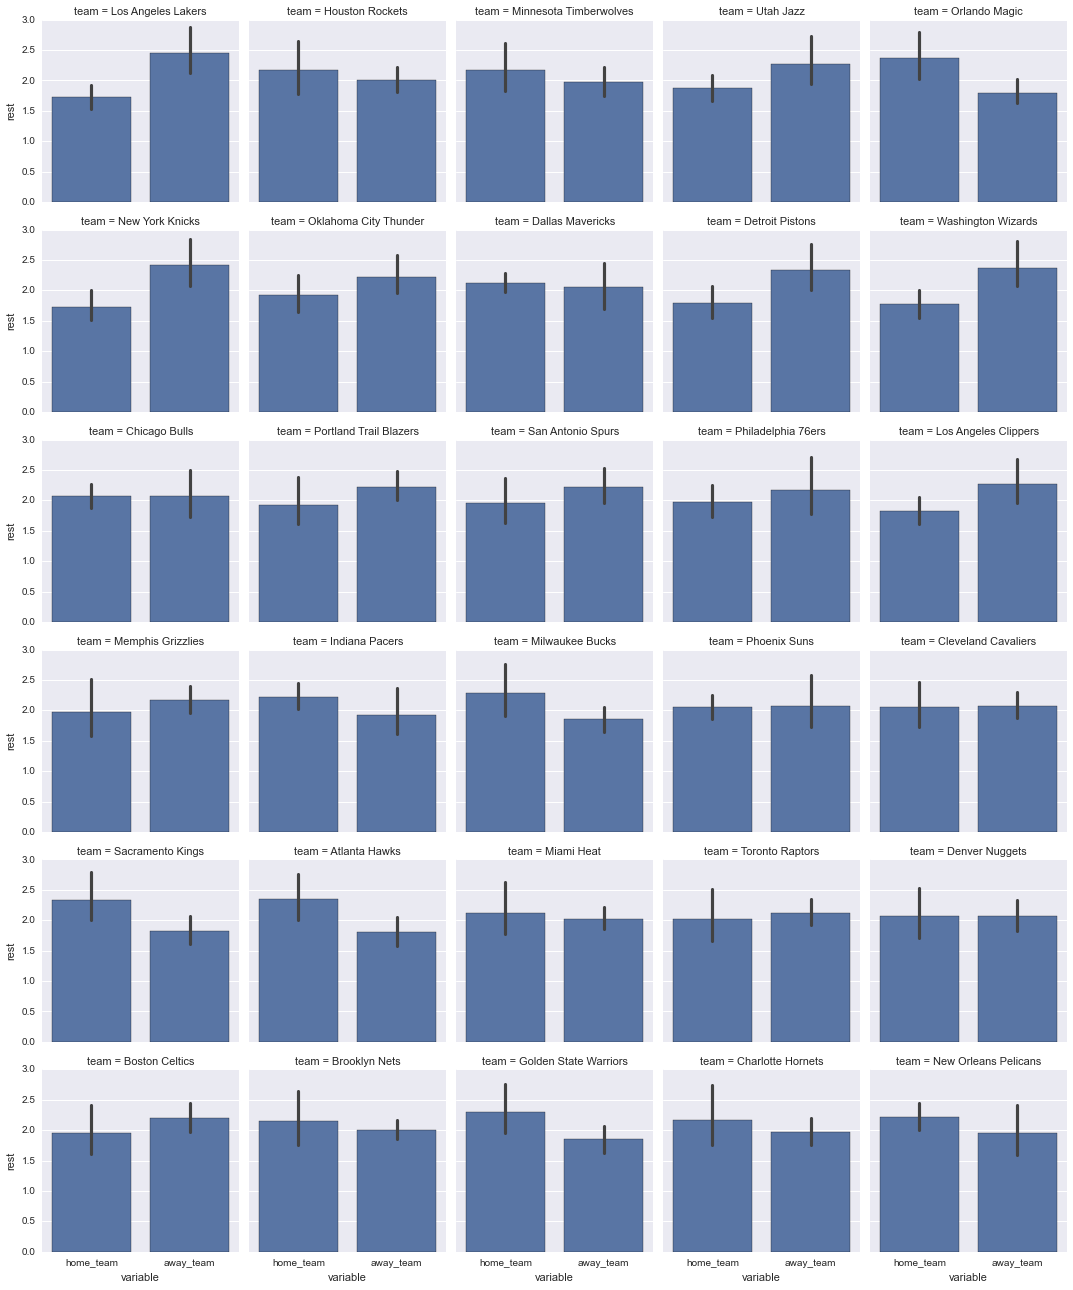

In [210]:
g = sns.FacetGrid(data=m.dropna(), col='team', col_wrap=5)
g.map(sns.barplot, "variable", "rest")